## Argo Test

In this notebook I'm attempting to replicate some of the glider results with Argo data in the region of 30E-40E and 50S-55S.

In [702]:
import scipy
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from argopy import DataFetcher as ArgoDataFetcher
argo_loader = ArgoDataFetcher(parallel=True)
import scipy.ndimage as filter
filter.gaussian_filter1d

<function scipy.ndimage._filters.gaussian_filter1d(input, sigma, axis=-1, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)>

## Load Points, Make Profiles, Remove Profiles with Sampling Frequency Less Than 2m

In [703]:
#ds = argo_loader.region([30,40,-55,-50,0,2000]).to_xarray()
#ds=ds.argo.point2profile()

In [705]:
#ds.to_netcdf("argo_box_lon_{}-{}_lat_{}-{}.nc".format(30,40,-55,-50))

In [706]:
ds=xr.open_dataset("downloaded_data/argo_box_lon_30-40_lat_-55--50.nc")

In [743]:
depth_min=200
depth_max=2000
sample_max=3

median_dp=ds.PRES.where(ds.PRES<depth_max).where(ds.PRES>depth_min).diff('N_LEVELS').median('N_LEVELS')
ind_rate=median_dp.where(median_dp<sample_max,drop=True).N_PROF
ds_sel=ds.sel(N_PROF=ind_rate)
ds_interp=ds_sel.argo.interp_std_levels(np.arange(depth_min,1750,2))
ds_interp=ds_interp.sortby(ds_interp.N_PROF)

In [760]:
def get_ds_interp(ds,depth_min,depth_max,sample_max):
    median_dp=ds.PRES.where(ds.PRES<depth_max).where(ds.PRES>depth_min).diff('N_LEVELS').median('N_LEVELS')
    ind_rate=median_dp.where(median_dp<sample_max,drop=True).N_PROF
    ds_sel=ds.sel(N_PROF=ind_rate)
    ds_interp=ds_sel.argo.interp_std_levels(np.arange(depth_min,depth_max,2))
    ds_interp=ds_interp.sortby(ds_interp.N_PROF)
    return ds_interp.TEMP

In [761]:
CT_interp=get_ds_interp(ds,200,1800,3)

In [762]:
CT_interp

<xarray.DataArray 'TEMP' (N_PROF: 297, PRES_INTERPOLATED: 800)>
array([[0.762     , 0.76952934, 0.796     , ..., 1.109     , 1.1110392 ,
        1.113     ],
       [1.3587192 , 1.3763198 , 1.3752589 , ..., 0.7477809 , 0.74671555,
        0.74597734],
       [0.9682457 , 0.9864697 , 0.99934113, ..., 0.97285724, 0.97190154,
        0.97125727],
       ...,
       [2.151     , 2.248     , 2.29208   , ..., 1.648     , 1.64798   ,
        1.6469423 ],
       [2.377     , 2.377     , 2.377     , ..., 1.54      , 1.5349607 ,
        1.533     ],
       [2.0544903 , 2.029     , 2.0005686 , ..., 1.471     , 1.47      ,
        1.47002   ]], dtype=float32)
Coordinates:
  * N_PROF             (N_PROF) int64 609 610 611 612 ... 2084 2088 2092 2096
    LATITUDE           (N_PROF) float64 -53.22 -54.97 -52.38 ... -51.43 -53.14
    LONGITUDE          (N_PROF) float64 30.12 30.73 30.57 ... 34.23 35.55 37.91
    TIME               (N_PROF) datetime64[ns] 2015-11-27T11:05:41 ... 2022-0...
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 200 202 204 ... 1794 1796 1798
Attributes:
    casted:   1

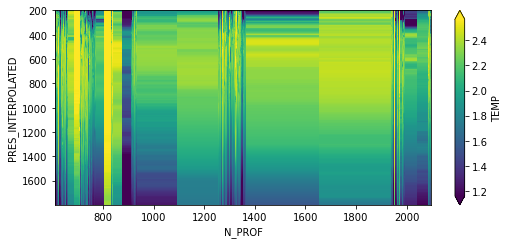

In [763]:
CT_interp.plot(y='PRES_INTERPOLATED',robust=True)
plt.gca().invert_yaxis()

## Filtering Analysis

In [764]:
def get_ds_filt(ds_interp,first,last,num):
    sigmas=np.logspace(first,last,num)
    temp=np.zeros((ds_interp.N_PROF.shape[0],ds_interp.PRES_INTERPOLATED.shape[0],num))

    for n in range(0,num):
        temp[:,:,n]=filter.gaussian_filter1d(ds_interp,sigma=sigmas[n],mode='nearest')

    ds_filt=xr.DataArray(temp,dims=['N_PROF','PRES_INTERPOLATED','FILT_SCALE'],
             coords={'N_PROF':ds_interp.N_PROF,'PRES_INTERPOLATED':ds_interp.PRES_INTERPOLATED,'FILT_SCALE':sigmas})
    return ds_filt

In [765]:
CT_filt=get_ds_filt(CT_interp,0.5,2.5,50)

In [766]:
CT_filt

<xarray.DataArray (N_PROF: 297, PRES_INTERPOLATED: 800, FILT_SCALE: 50)>
array([[[0.77772939, 0.77783644, 0.77781725, ..., 1.38432193,
         1.37506104, 1.36336601],
        [0.78264666, 0.78203112, 0.78142315, ..., 1.38617337,
         1.37667084, 1.3647573 ],
        [0.78693342, 0.78568661, 0.78461468, ..., 1.3880235 ,
         1.37827933, 1.3661474 ],
        ...,
        [1.11049831, 1.11105788, 1.11173403, ..., 1.3123796 ,
         1.32677758, 1.33959126],
        [1.11063802, 1.1109606 , 1.1113925 , ..., 1.31148112,
         1.32591867, 1.33878982],
        [1.11107385, 1.11119568, 1.11141467, ..., 1.31058502,
         1.32506144, 1.33798945]],

       [[1.38798416, 1.39123106, 1.39454997, ..., 1.55577576,
         1.54056048, 1.52324402],
        [1.40212905, 1.40498269, 1.40783024, ..., 1.55617714,
         1.54083979, 1.52341604],
        [1.41925633, 1.42121589, 1.42315638, ..., 1.55657637,
         1.54111695, 1.52358615],
...
        [1.53893638, 1.53901637, 1.53910518, ..., 1.70039463,
         1.7139442 , 1.72786343],
        [1.53747773, 1.53764021, 1.53780925, ..., 1.69963014,
         1.71319747, 1.72713888],
        [1.53618586, 1.5364089 , 1.53663754, ..., 1.69886768,
         1.71245241, 1.72641587]],

       [[2.02989793, 2.02923131, 2.02884102, ..., 2.09294653,
         2.08954501, 2.08407283],
        [2.0215857 , 2.02188921, 2.02252984, ..., 2.09307694,
         2.08962226, 2.08409762],
        [2.01347876, 2.01496291, 2.01685905, ..., 2.09320688,
         2.08969903, 2.0841217 ],
        ...,
        [1.46997595, 1.46989   , 1.46981668, ..., 1.65502346,
         1.66700745, 1.67834246],
        [1.47009659, 1.47002196, 1.46994925, ..., 1.6541996 ,
         1.66622603, 1.67760801],
        [1.47013986, 1.47008932, 1.47003198, ..., 1.65337765,
         1.66544604, 1.67687464]]])
Coordinates:
  * N_PROF             (N_PROF) int64 609 610 611 612 ... 2084 2088 2092 2096
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 200 202 204 ... 1794 1796 1798
  * FILT_SCALE         (FILT_SCALE) float64 3.162 3.474 3.816 ... 287.9 316.2

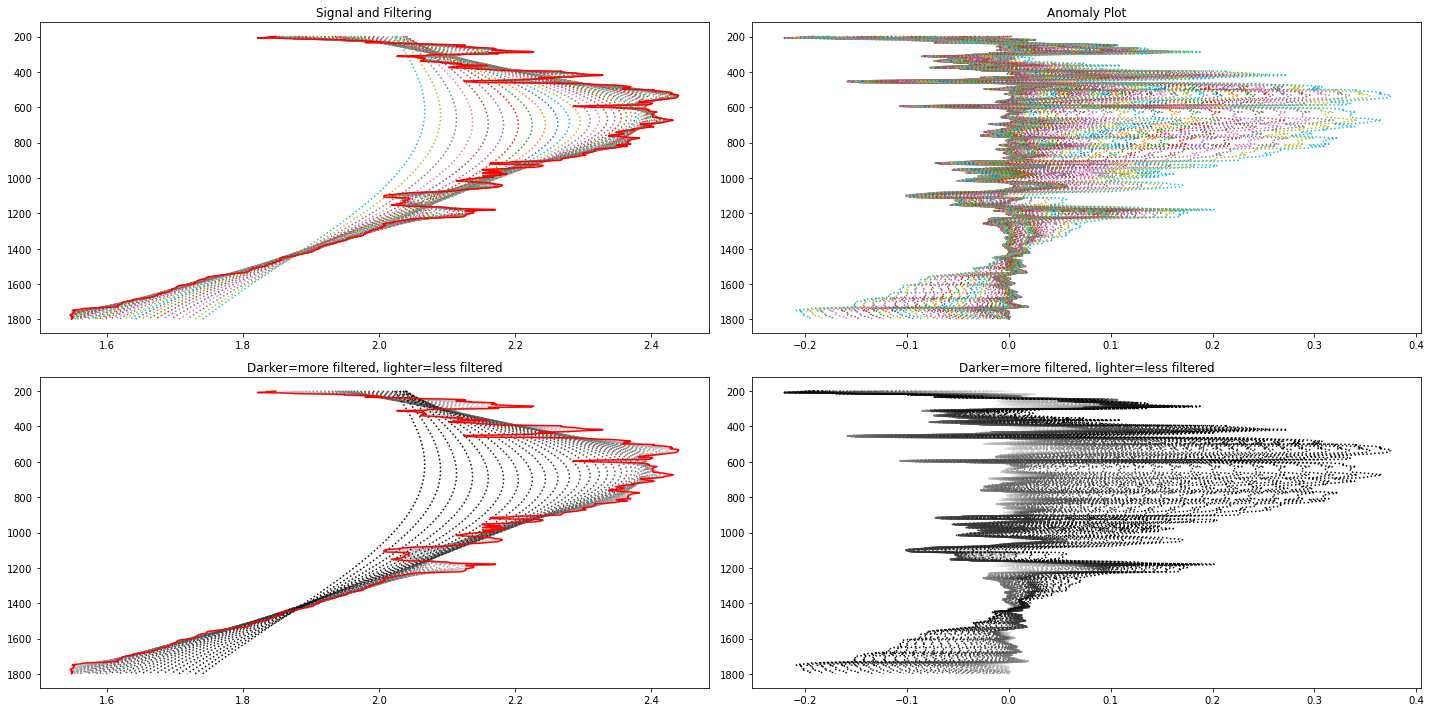

In [767]:
plt.figure(figsize=(20,10))
color=np.arange(0.01,1.01,1/len(CT_filt.FILT_SCALE))
color=np.flip(color,0)
prof_num=CT_filt.N_PROF[50]
prof=CT_interp.sel(N_PROF=prof_num)

plt.subplot(2,2,1)
plt.plot(prof,prof.PRES_INTERPOLATED,color='red',zorder=100)
plt.gca().invert_yaxis()
plt.title("Signal and Filtering")

plt.subplot(2,2,2)
plt.gca().invert_yaxis()
plt.title("Anomaly Plot")

plt.subplot(2,2,3)
plt.plot(prof,prof.PRES_INTERPOLATED,color='red',zorder=100)
plt.gca().invert_yaxis()
plt.title("Darker=more filtered, lighter=less filtered")

plt.subplot(2,2,4)
plt.gca().invert_yaxis()
plt.title("Darker=more filtered, lighter=less filtered")

#n regulates color only\
#sigma regulates FILT_SCALE

for n,sig in enumerate(CT_filt.FILT_SCALE):
    filt=CT_filt.sel(N_PROF=prof_num,FILT_SCALE=sig)
    anom=prof-filt
    
    plt.subplot(2,2,1)
    plt.plot(filt,filt.PRES_INTERPOLATED,linestyle=':')
    
    plt.subplot(2,2,2)
    plt.plot(anom,anom.PRES_INTERPOLATED,linestyle=':')
    
    plt.subplot(2,2,3)
    plt.plot(filt,filt.PRES_INTERPOLATED,linestyle=':',color=str(color[n]))
    
    plt.subplot(2,2,4)
    plt.plot(anom,anom.PRES_INTERPOLATED,linestyle=':',color=str(color[n]))

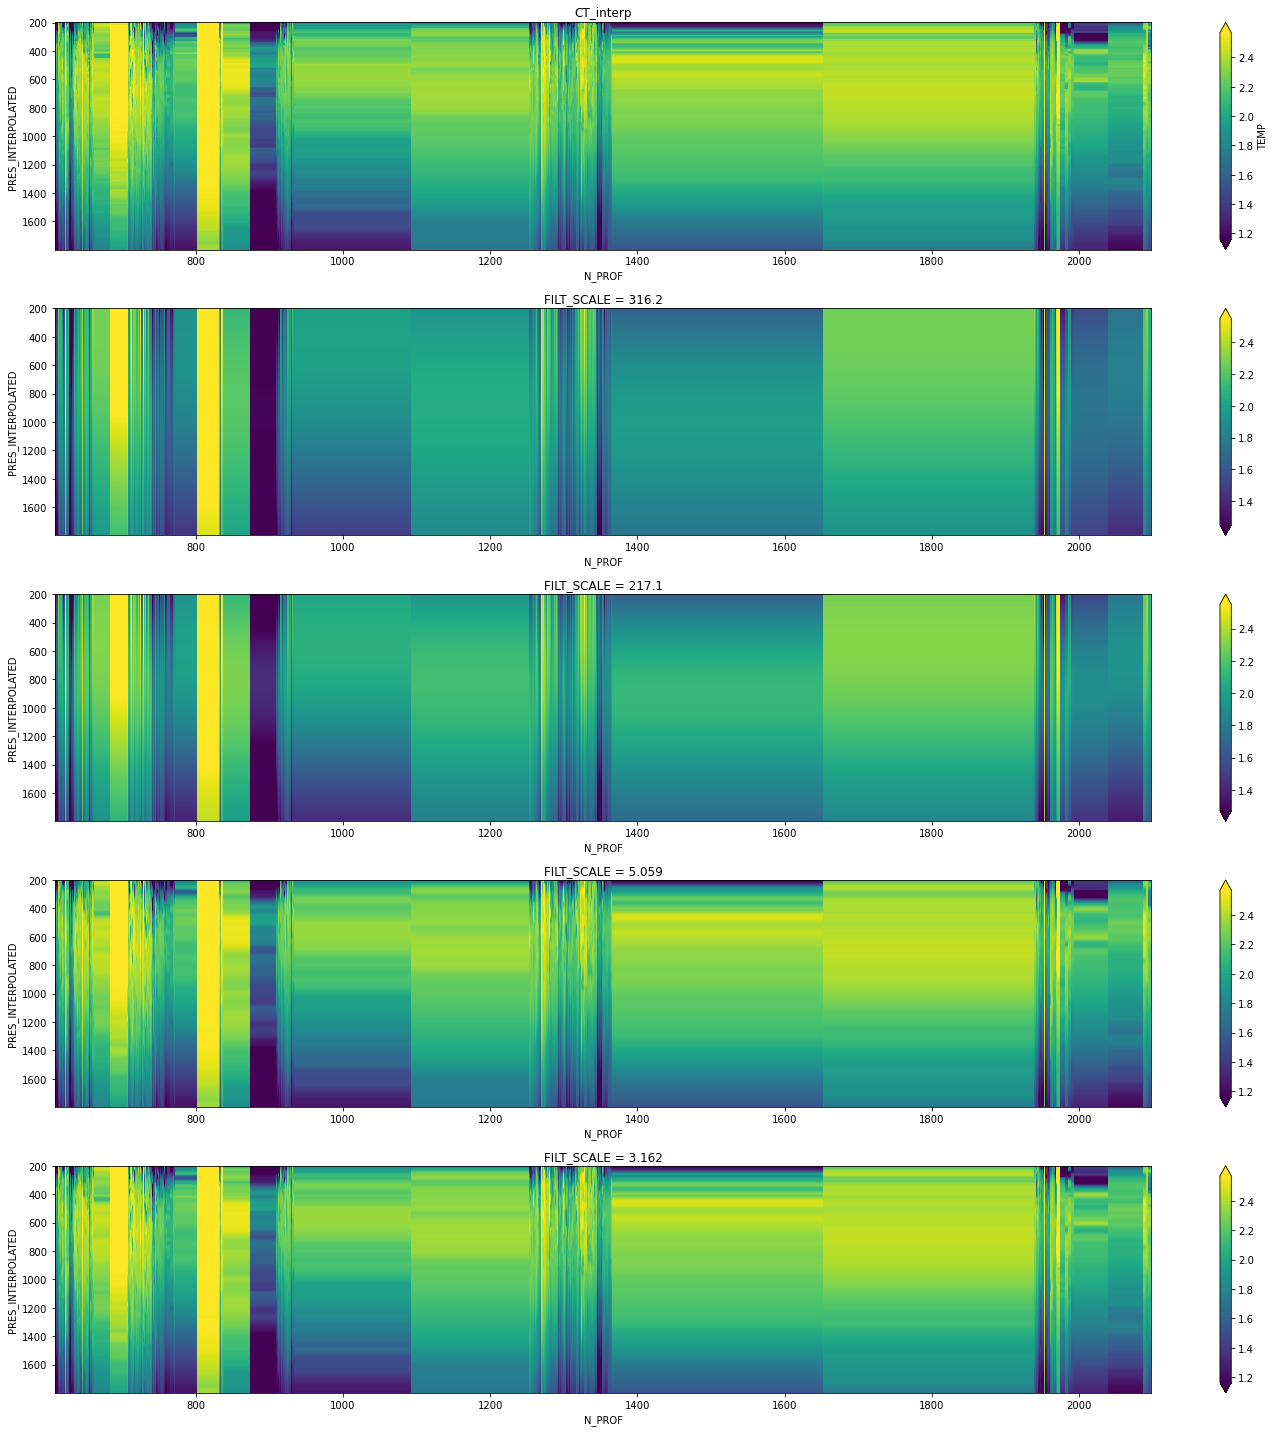

In [768]:
plt.figure(figsize=(20,20))
plt.subplot(5,1,1)
CT_interp.plot(y='PRES_INTERPOLATED',robust=True)
plt.title("CT_interp")
plt.gca().invert_yaxis()

scales=(CT_filt.FILT_SCALE[-1],CT_filt.FILT_SCALE[-5],CT_filt.FILT_SCALE[5],CT_filt.FILT_SCALE[0])
for n,sig in enumerate(scales):
    filt=CT_filt.sel(FILT_SCALE=sig)
    plt.subplot(5,1,n+2)
    filt.plot(y='PRES_INTERPOLATED',robust=True)
    plt.gca().invert_yaxis()
    
plt.subplots_adjust(hspace=0.4)

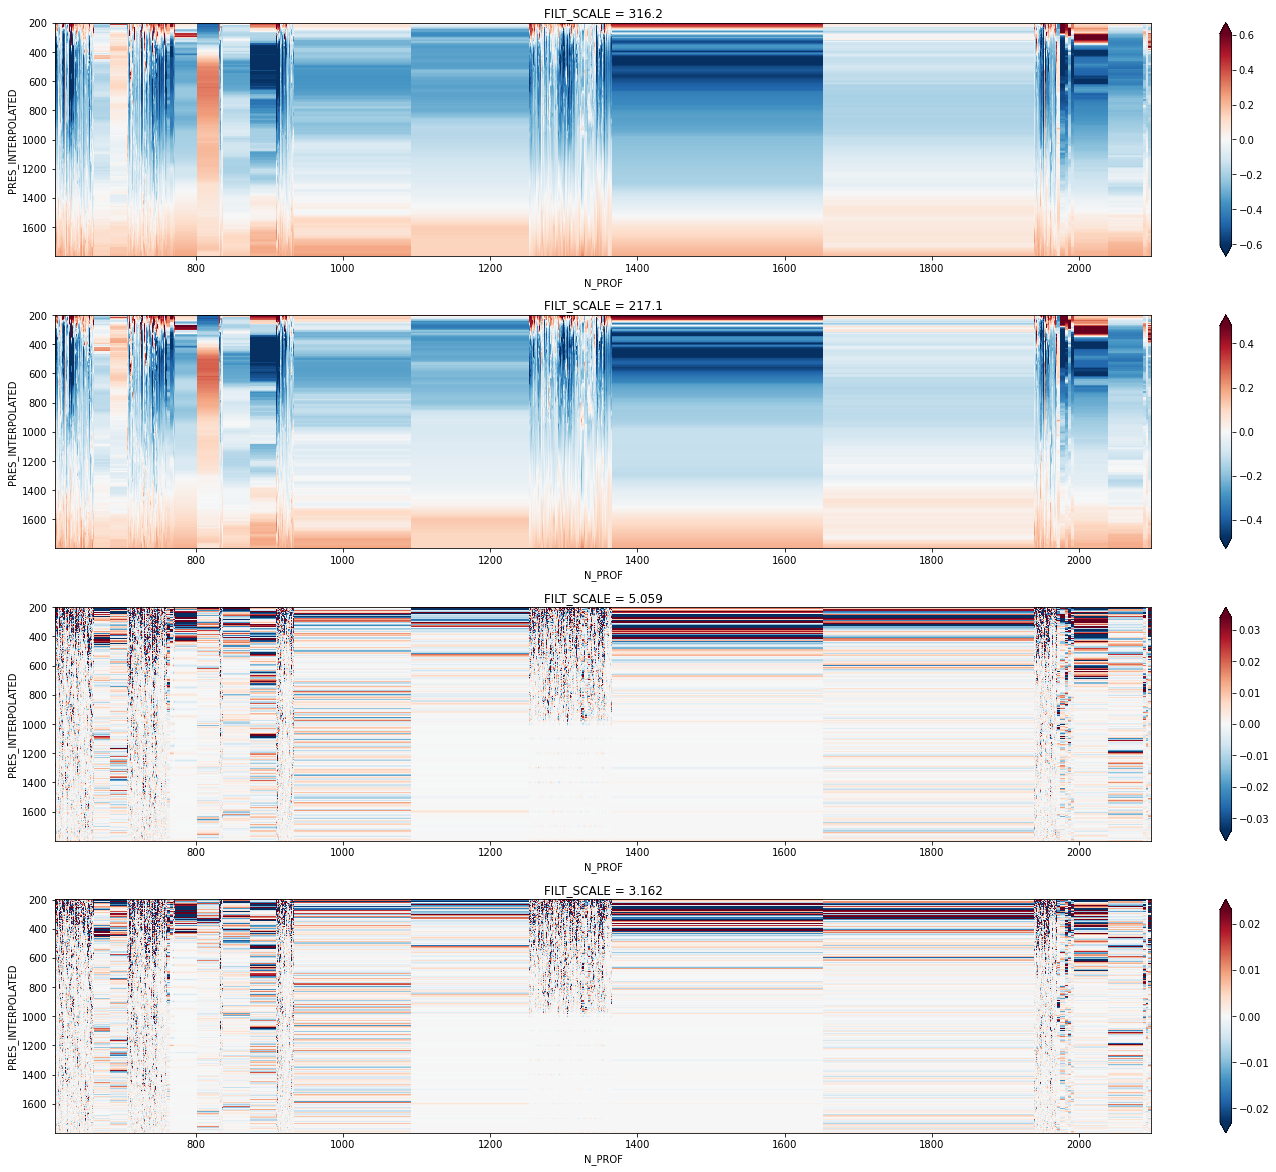

In [769]:
plt.figure(figsize=(20,20))

scales=(CT_filt.FILT_SCALE[-1],CT_filt.FILT_SCALE[-5],CT_filt.FILT_SCALE[5],CT_filt.FILT_SCALE[0])
for n,sig in enumerate(scales):
    filt=CT_filt.sel(FILT_SCALE=sig)
    anom=filt-CT_interp
    plt.subplot(5,1,n+1)
    anom.plot(y='PRES_INTERPOLATED',robust=True)
    plt.gca().invert_yaxis()
    
plt.subplots_adjust(hspace=0.4)

In [770]:
var_scale=np.zeros(len(CT_filt.FILT_SCALE))

for n,sig in enumerate(CT_filt.FILT_SCALE):
    prof=CT_filt.sel(FILT_SCALE=sig)
    var_scale[n]=(prof-CT_interp).var()

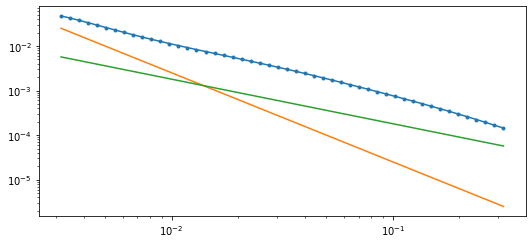

In [771]:
plt.plot(1/CT_filt.FILT_SCALE,var_scale,'.-')
plt.xscale('log')
plt.yscale('log')

x=1/CT_filt.FILT_SCALE
y_2=2.5*10**-7*x**-2
y_1=1.8*10**-5*x**-1

plt.plot(x,y_2)
plt.plot(x,y_1)

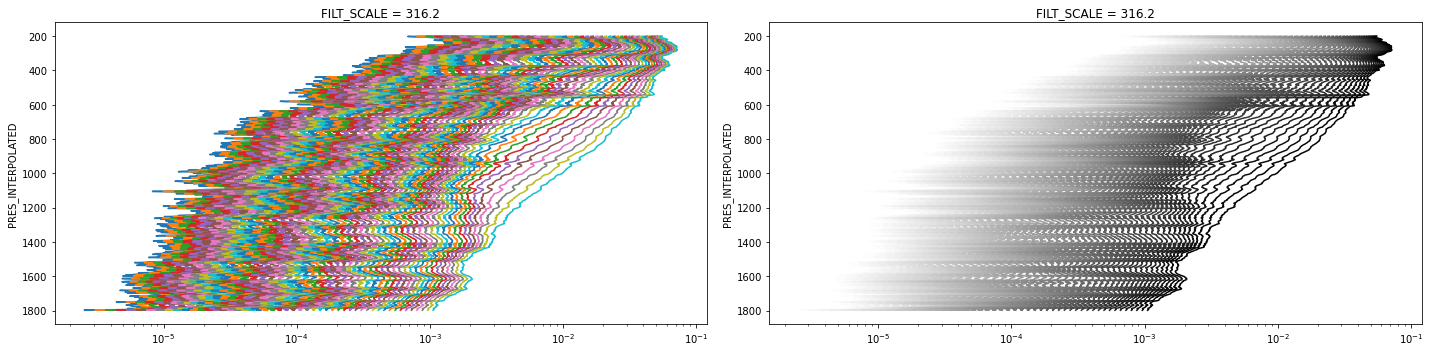

In [772]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.gca().invert_yaxis()
plt.xscale('log')

plt.subplot(1,2,2)
plt.gca().invert_yaxis()
plt.xscale('log')

for n,sig in enumerate(CT_filt.FILT_SCALE):
    prof=CT_filt.sel(FILT_SCALE=sig)
    
    plt.subplot(1,2,1)
    (prof-CT_interp).var(['N_PROF']).plot(y='PRES_INTERPOLATED',label=sig)
    
    plt.subplot(1,2,2)
    (prof-CT_interp).var(['N_PROF']).plot(y='PRES_INTERPOLATED',label=sig,color=str(color[n]))

In [773]:
interp_1000_3=get_ds_interp(ds,0,1000,3)
interp_2000_3=get_ds_interp(ds,1000,2000,3)
interp_1000_12=get_ds_interp(ds,0,1000,12)
interp_2000_12=get_ds_interp(ds,1000,2000,12)

In [774]:
filt_1000_3=get_ds_filt(interp_1000_3,0.5,2.5,50)
filt_2000_3=get_ds_filt(interp_2000_3,0.5,2.5,50)
filt_1000_12=get_ds_filt(interp_1000_12,0.5,2.5,50)
filt_2000_12=get_ds_filt(interp_2000_12,0.5,2.5,50)

In [775]:
var_1000_3=np.zeros(len(filt_1000_3.FILT_SCALE))
var_2000_3=np.zeros(len(filt_1000_3.FILT_SCALE))
var_1000_12=np.zeros(len(filt_1000_3.FILT_SCALE))
var_2000_12=np.zeros(len(filt_1000_3.FILT_SCALE))

for n,sig in enumerate(filt_1000_3.FILT_SCALE):
    prof_1000_3=filt_1000_3.sel(FILT_SCALE=sig,method='nearest')
    var_1000_3[n]=(prof_1000_3-interp_1000_3).var()
    
    prof_2000_3=filt_2000_3.sel(FILT_SCALE=sig,method='nearest')
    var_2000_3[n]=(prof_2000_3-interp_2000_3).var()
    
    prof_1000_12=filt_1000_12.sel(FILT_SCALE=sig,method='nearest')
    var_1000_12[n]=(prof_1000_12-interp_1000_12).var()
    
    prof_2000_12=filt_2000_12.sel(FILT_SCALE=sig,method='nearest')
    var_2000_12[n]=(prof_2000_12-interp_2000_12).var()

Text(0.5, 1.0, 'depth: [1000,2000]')

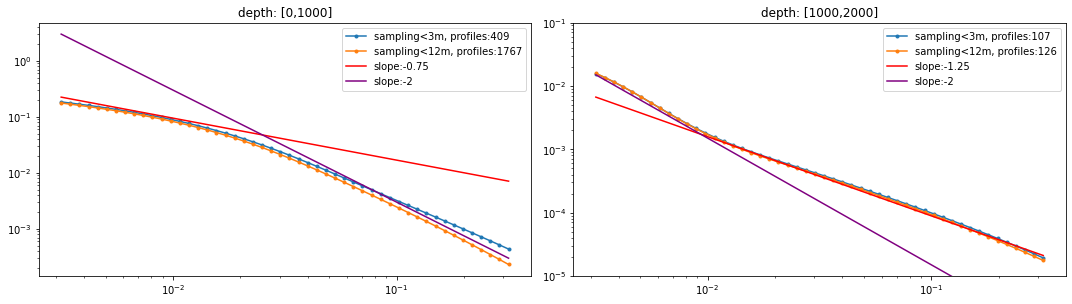

In [791]:
plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
plt.plot(1/filt_1000_3.FILT_SCALE,var_1000_3,'.-',label='sampling<3m, profiles:{}'.format(interp_1000_3.N_PROF.shape[0]))
plt.plot(1/filt_1000_12.FILT_SCALE,var_1000_12,'.-',label='sampling<12m, profiles:{}'.format(interp_1000_12.N_PROF.shape[0]))
plt.xscale('log')
plt.yscale('log')
x=1/filt_1000_3.FILT_SCALE
y_075=3*10**-3*x**-0.75
y_2=3*10**-5*x**-2
plt.plot(x,y_075,label='slope:-0.75',color='red')
plt.plot(x,y_2,label='slope:-2',color='purple')
plt.legend()
#plt.ylim(10**-5,10**-1)
plt.title("depth: [0,1000]")

plt.subplot(2,2,2)
plt.plot(1/filt_2000_3.FILT_SCALE,var_2000_3,'.-',label='sampling<3m, profiles:{}'.format(interp_2000_3.N_PROF.shape[0]))
plt.plot(1/filt_2000_12.FILT_SCALE,var_2000_12,'.-',label='sampling<12m, profiles:{}'.format(interp_2000_12.N_PROF.shape[0]))
plt.xscale('log')
plt.yscale('log')
x=1/filt_2000_3.FILT_SCALE
y_125=5*10**-6*x**-1.25
y_2=1.5*10**-7*x**-2
plt.plot(x,y_125,label='slope:-1.25',color='red')
plt.plot(x,y_2,label='slope:-2',color='purple')
plt.legend()
plt.ylim(10**-5,10**-1)
plt.title("depth: [1000,2000]")